In [188]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio
import os 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten

In [319]:
import glob
c1 = glob.glob('Data/chest_xray/train/*/*')
c2 = glob.glob('Data/chest_xray/test/*/*')

print('# Train images : {} \n# Test images : {}'.format(len(c1), len(c2)))

# Train images : 5216 
# Test images : 624


## Loading, resizing, classifying images

In [298]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
          
def returnLabel(path):
    imgClass = tf.strings.split(path,'/')[-2]
    return 0 if imgClass == 'NORMAL' else 1

def returnImg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    imgClass = returnLabel(path)
    return tf.image.resize(img, (256,256)), imgClass

In [299]:
train_path = 'Data/chest_xray/train'
list_ds = tf.data.Dataset.list_files(str(train_path+'/*/*'))
labeled_ds = list_ds.map(returnImg, num_parallel_calls=AUTOTUNE)
labeled_ds

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

## Model


In [320]:
class AccuracyHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

history = AccuracyHistory()

In [321]:
def nn_model():
    model = Sequential()
    
    model.add(Conv2D(8,5, strides=(5,5), padding='SAME', activation='relu', use_bias=True))
    model.add(AveragePooling2D(pool_size=(2,2), data_format='channels_last'))
    
    model.add(Conv2D(10, 5, activation='relu', use_bias=True))
    model.add(AveragePooling2D(pool_size=(2,2), strides=(1,1), data_format='channels_last'))
    
    model.add(Flatten())
    
    model.add(Dense(120, activation='relu', use_bias=True))
    model.add(Dense(84, activation='relu', use_bias=True))
    model.add(Dense(1, activation='sigmoid', use_bias=True))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics=['accuracy'])
    
    return model
    

In [326]:
epoch = 75
batch_size = 128
seed = 1 
labeled_data = labeled_ds.batch(5300)
model = nn_model()

model.fit(labeled_data, batch_size=128, epochs=epoch, verbose=1, callbacks=[history])

Epoch 1/75
1/1 [==============================] - 0s 1ms/step - loss: 0.6679 - accuracy: 0.7427
Epoch 2/75
1/1 [==============================] - 0s 1ms/step - loss: 0.5746 - accuracy: 0.7429
Epoch 3/75
1/1 [==============================] - 0s 1ms/step - loss: 0.5632 - accuracy: 0.7429
Epoch 4/75
1/1 [==============================] - 0s 2ms/step - loss: 0.5543 - accuracy: 0.7429
Epoch 5/75
1/1 [==============================] - 0s 1ms/step - loss: 0.5431 - accuracy: 0.7429
Epoch 6/75
1/1 [==============================] - 0s 978us/step - loss: 0.5318 - accuracy: 0.7429
Epoch 7/75
1/1 [==============================] - 0s 1ms/step - loss: 0.5207 - accuracy: 0.7429
Epoch 8/75
1/1 [==============================] - 0s 1ms/step - loss: 0.5049 - accuracy: 0.7429
Epoch 9/75
1/1 [==============================] - 0s 1ms/step - loss: 0.4864 - accuracy: 0.7429
Epoch 10/75
1/1 [==============================] - 0s 1ms/step - loss: 0.4634 - accuracy: 0.7431
Epoch 11/75
1/1 [====================

In [300]:
labeled_ds

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

## Testing

In [332]:
def testing(model, test_dataset):    
    return model.evaluate(test_dataset, verbose = 1, batch_size=128, return_dict=True)
    

In [333]:
test_path = 'Data/chest_xray/test'
test_ds = tf.data.Dataset.list_files(str(train_path+'/*/*'))
test_labeled = test_ds.map(returnImg, num_parallel_calls=AUTOTUNE)
test_labeled = test_labeled.batch(1000)

In [334]:
score = testing(model, test_labeled)

6/6 [==============================] - 17s 3s/step - loss: 0.1046 - accuracy: 0.9599


5216


In [306]:
hist = model.history

In [307]:
hist.acc

In [308]:
history_backup = history

In [327]:
history.acc

[0.7427147030830383,
 0.7429064512252808,
 0.7429064512252808,
 0.7429064512252808,
 0.7429064512252808,
 0.7429064512252808,
 0.7429064512252808,
 0.7429064512252808,
 0.7429064512252808,
 0.7430981397628784,
 0.7580521702766418,
 0.8086656332015991,
 0.8270705342292786,
 0.866180956363678,
 0.8886119723320007,
 0.8886119723320007,
 0.887269914150238,
 0.8508435487747192,
 0.8995398879051208,
 0.8606211543083191,
 0.9066334366798401,
 0.8778757452964783,
 0.9001150131225586,
 0.8972392678260803,
 0.894363522529602,
 0.9144938588142395,
 0.8999233245849609,
 0.9162193536758423,
 0.9175613522529602,
 0.9137269854545593,
 0.9261886477470398,
 0.9190950989723206,
 0.9284892678260803,
 0.9323236346244812,
 0.9265720844268799,
 0.9355828166007996,
 0.9309815764427185,
 0.9365414381027222,
 0.9384585618972778,
 0.9409509301185608,
 0.9403757452964783,
 0.9394171833992004,
 0.9451687335968018,
 0.9449769854545593,
 0.9455521702766418,
 0.9426763653755188,
 0.9474693536758423,
 0.9484279155731

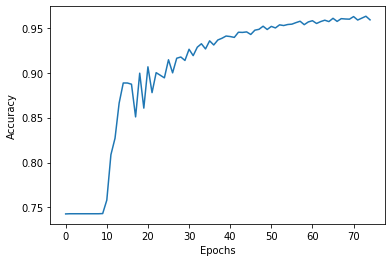

In [331]:
plt.plot(range(75), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('75epoch.jpeg')